# Results


**TODO**
- How should I incorporate replicate information?


These amplicons are working:
- HRP2, HRP2up, HRP2dwn
- HRP3, HRP3dwn
    - HRP3up has low coverage overall

In [129]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 100

## Settings

In [130]:
expt_dir =  "../experiments/2022-03-15_large-lab-validation-r1/" + \
            "nomadic/guppy/hac/single_end"

In [131]:
target_dir = f"{expt_dir}/target-extraction"

In [132]:
target_df = pd.read_csv(f"{target_dir}/table.target_coverage.overview.csv")

## Munge

- Reduce to key columns
- Compute total coverage
- Normalise
- Add control column


In [165]:
# Limit to key columns
key_columns = [
    "reads_total", 
#     "mean_read_qual", 
#     "mean_read_length",
    "overlap",
    "barcode",
    "sample_id",
    "strains", 
    "proportions",
    "gene_name",
    "parasites_per_ul"
]
focus_df = target_df[key_columns]

In [166]:
# For now, limit to any overlapping reads
OVERLAP = "any"
focus_df = focus_df.query("overlap == @OVERLAP")

In [167]:
# Compute total reads per barcode, add as column
barcode_reads_total = focus_df.groupby("barcode")["reads_total"].sum()
focus_df.insert(1, 
                "barcode_reads_total",
                [barcode_reads_total.loc[b] for b in focus_df["barcode"]]
               )

In [168]:
# Compute proportion of reads to each gene
focus_df.insert(1, 
                "prop_reads_total", 
                focus_df["reads_total"]/focus_df["barcode_reads_total"])

In [169]:
focus_df

,reads_total,prop_reads_total,barcode_reads_total,overlap,barcode,sample_id,strains,proportions,gene_name,parasites_per_ul
0,1.0,0.055556,18.0,any,barcode01,3D7_10000,3D7,1,CRT1,10000
2,2.0,0.111111,18.0,any,barcode01,3D7_10000,3D7,1,K13,10000
4,3.0,0.166667,18.0,any,barcode01,3D7_10000,3D7,1,DHFR,10000
6,0.0,0.000000,18.0,any,barcode01,3D7_10000,3D7,1,MSP2,10000
8,1.0,0.055556,18.0,any,barcode01,3D7_10000,3D7,1,DHPS,10000
...,...,...,...,...,...,...,...,...,...,...
2934,2900.0,0.051449,56366.0,any,barcode96,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,HRP2dwn,10000
2936,113.0,0.002005,56366.0,any,barcode96,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,HRP3up,10000
2938,1607.0,0.028510,56366.0,any,barcode96,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,HRP3dwn,10000
2940,3259.0,0.057819,56366.0,any,barcode96,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,AMA1,10000


In [170]:
# Label controls
focus_df.insert(5, "ntc", focus_df["strains"].isnull())

In [173]:
# Add strain proportion columns

In [181]:
results = {}
target_strains = ["3d7", "Dd2", "HB3", "1236G", "1237G"]
for target in target_strains:
    
    c = f"{target}_prop"
    results[c] = []
    target = target.lower()
    
    for _, row in focus_df.iterrows():
        
        # If there is no strain, it is NTC
        if pd.isnull(row["strains"]):
            results[c].append(0)
            continue

        # Get strians in this sample
        strains = [s.lower() for s in row["strains"].split(":")]

        # If target strain not present, add zero
        if not target in strains:
            results[c].append(0)
            continue

        # Else, add it's proportion
        ix = strains.index(target)
        proportions = row["proportions"].split(":")
        results[c].append(float(proportions[ix]))
        
    focus_df[c] = results[c]

In [182]:
focus_df

,reads_total,prop_reads_total,barcode_reads_total,overlap,barcode,ntc,sample_id,strains,proportions,gene_name,parasites_per_ul,3d7_prop,Dd2_prop,HB3_prop,1236G_prop,1237G_prop
0,1.0,0.055556,18.0,any,barcode01,False,3D7_10000,3D7,1,CRT1,10000,1.0,0.0,0.0,0.0,0.0
2,2.0,0.111111,18.0,any,barcode01,False,3D7_10000,3D7,1,K13,10000,1.0,0.0,0.0,0.0,0.0
4,3.0,0.166667,18.0,any,barcode01,False,3D7_10000,3D7,1,DHFR,10000,1.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,18.0,any,barcode01,False,3D7_10000,3D7,1,MSP2,10000,1.0,0.0,0.0,0.0,0.0
8,1.0,0.055556,18.0,any,barcode01,False,3D7_10000,3D7,1,DHPS,10000,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2900.0,0.051449,56366.0,any,barcode96,False,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,HRP2dwn,10000,0.0,0.0,0.0,0.1,0.9
2936,113.0,0.002005,56366.0,any,barcode96,False,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,HRP3up,10000,0.0,0.0,0.0,0.1,0.9
2938,1607.0,0.028510,56366.0,any,barcode96,False,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,HRP3dwn,10000,0.0,0.0,0.0,0.1,0.9
2940,3259.0,0.057819,56366.0,any,barcode96,False,1236G:1237G_0.1:0.9_Rep2,1236G:1237G,0.1:0.9,AMA1,10000,0.0,0.0,0.0,0.1,0.9


## Explore

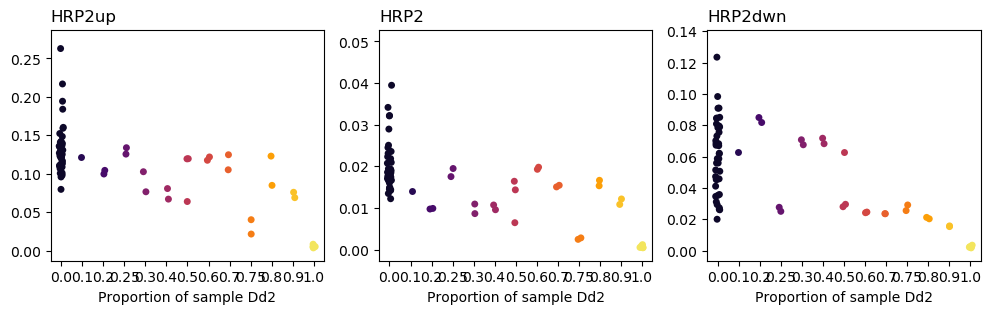

In [243]:
MIN_COVERAGE = 10_000


focus_genes = ["HRP2up", "HRP2", "HRP2dwn"]
n_genes = len(focus_genes)

fig, axes = plt.subplots(1, n_genes, figsize=(n_genes*4, 3))
fig.subplots_adjust(wspace=0.2)

for gene, ax in zip(focus_genes, axes.flatten()):
    
    # Plot
    sns.stripplot(
        x="Dd2_prop",
        y="prop_reads_total",
        palette="inferno",
        data=(focus_df
              .query(f"gene_name == '{gene}'")
              .query("~ntc")
              .query(f"barcode_reads_total > {MIN_COVERAGE}")
             ),
        ax=ax
    )
    
    # X-axis label
    ax.set_xlabel("Proportion of sample Dd2")
    ax.set_ylabel("")
    ax.set_title(gene, loc="left")
    #ax.label_outer()

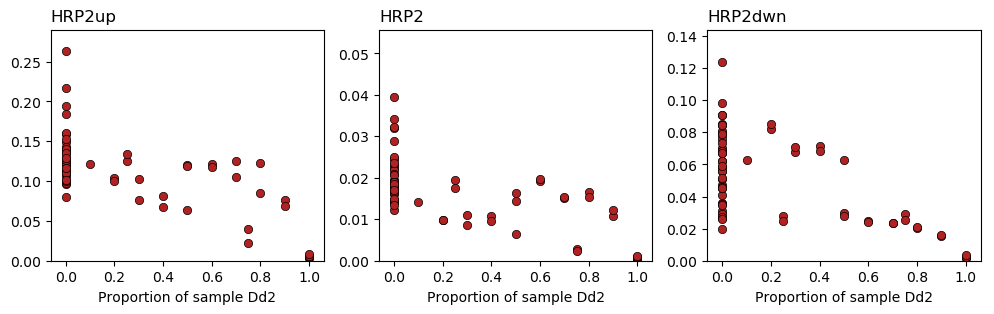

In [254]:
MIN_COVERAGE = 10_000


focus_genes = ["HRP2up", "HRP2", "HRP2dwn"]
n_genes = len(focus_genes)

fig, axes = plt.subplots(1, n_genes, figsize=(n_genes*4, 3))
fig.subplots_adjust(wspace=0.2)

for gene, ax in zip(focus_genes, axes.flatten()):
    
    # Plot
    ax.scatter(
        x="Dd2_prop",
        y="prop_reads_total",
        color='firebrick',
        edgecolor='black', lw=0.5,
        #palette="inferno",
        data=(focus_df
              .query(f"gene_name == '{gene}'")
              .query("~ntc")
              .query(f"barcode_reads_total > {MIN_COVERAGE}")
             )
    )
    
    # X-axis label
    ax.set_ylim((0, ax.get_ylim()[1]))
    ax.set_xlabel("Proportion of sample Dd2")
    ax.set_ylabel("")
    ax.set_title(gene, loc="left")
    #ax.label_outer()

- Good eough, but could be good to normalise to amount in zero
- Marginal histograms would be good
    - Prop = 0
    - Prop between 1 and 0
    - Prop 1

In [280]:
focus_df["Dd2_groups"] = \
pd.cut(focus_df["Dd2_prop"],
       bins=[-0.5, 0, 0.99, 1.5],
       labels=["No Dd2", "Mixed Dd2", "Clonal Dd2"])

In [284]:
focus_df["Dd2_groups"]

0       No Dd2
2       No Dd2
4       No Dd2
6       No Dd2
8       No Dd2
         ...  
2934    No Dd2
2936    No Dd2
2938    No Dd2
2940    No Dd2
2942    No Dd2
Name: Dd2_groups, Length: 1472, dtype: category
Categories (3, object): ['No Dd2' < 'Mixed Dd2' < 'Clonal Dd2']

In [281]:
gene = "HRP2"
grps = (focus_df
        .query(f"gene_name == '{gene}'")
        .query("~ntc")
        .query(f"barcode_reads_total > {MIN_COVERAGE}")
        .groupby("Dd2_groups")
       )

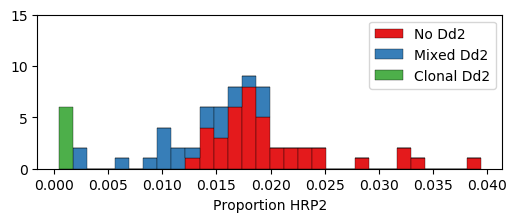

In [292]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))

sns.set_palette("Set1")
ax.hist([gdf["prop_reads_total"] for _, gdf in grps],
        #bins=np.arange(0, 0.1, 0.005),
        
        bins=30,
        ec='black', lw=0.25,
        label=[g for g, gdf in grps],
        stacked=True
       )
ax.set_ylim((0, 15))
ax.set_xlabel("Proportion HRP2")
ax.legend()

- These would be decent-ish marginals

(0, 1016.2586876328141)

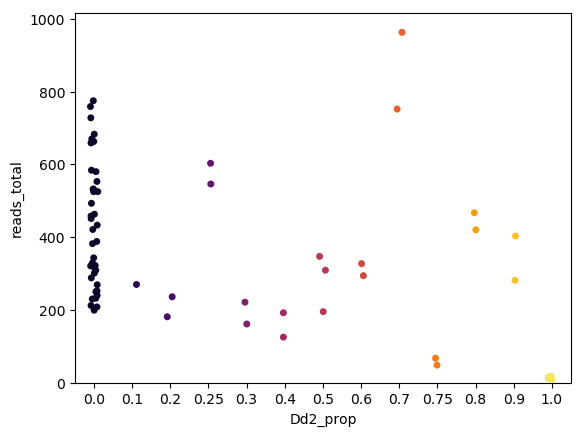

In [223]:
fig, ax = plt.subplots(1, 1)

sns.stripplot(
    x="Dd2_prop",
    y="reads_total",
    palette="inferno",
    data=(focus_df
          .query("gene_name == 'HRP2'")
          .query("~ntc")
          .query("barcode_reads_total > 10000")
         )
)

ax.set_ylim((0, ax.get_ylim()[1]))

(0, 0.04854440463233054)

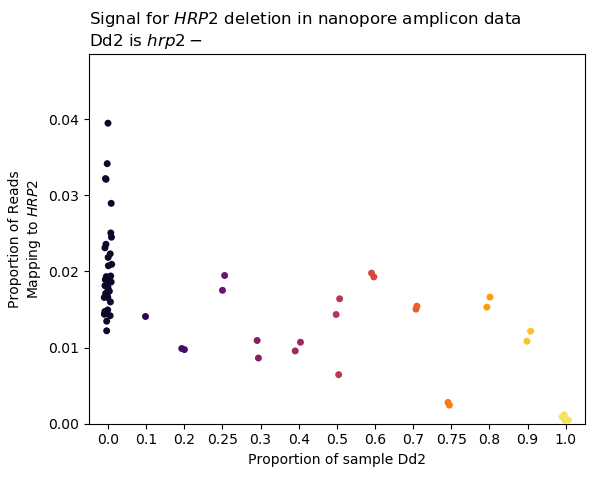

In [224]:
fig, ax = plt.subplots(1, 1)

sns.stripplot(
    x="Dd2_prop",
    y="prop_reads_total",
    palette="inferno",
    data=(focus_df
          .query("gene_name == 'HRP2'")
          .query("~ntc")
          .query("barcode_reads_total > 10000")
         )
)

ax.set_xlabel("Proportion of sample Dd2")
ax.set_ylabel("Proportion of Reads\nMapping to $HRP2$")
ax.set_title("Signal for $HRP2$ deletion in nanopore amplicon data\nDd2 is $hrp2-$", 
             loc='left')

ax.set_ylim((0, ax.get_ylim()[1]))

- This looks decent
- Want to integrate information across amplicons
- Good exersize to try and write down such a model

(0, 0.04455993650887181)

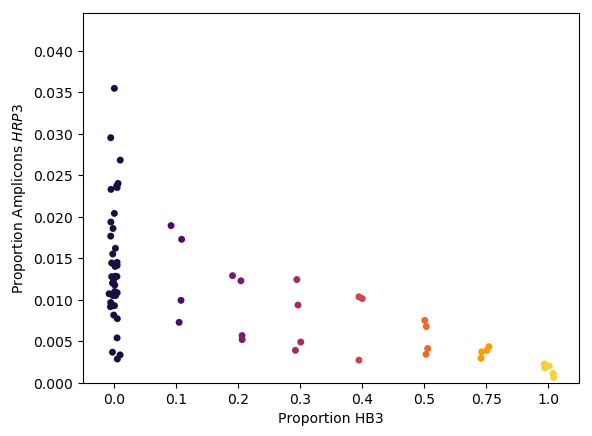

In [225]:
fig, ax = plt.subplots(1, 1)

sns.stripplot(
    x="HB3_prop",
    y="prop_reads_total",
    palette="inferno",
    data=(focus_df
          .query("gene_name == 'HRP3'")
          .query("~ntc")
          .query("barcode_reads_total > 10000")
         )
)

ax.set_xlabel("Proportion HB3")
ax.set_ylabel("Proportion Amplicons $HRP3$")

ax.set_ylim((0, ax.get_ylim()[1]))

(0, 0.08221275545836547)

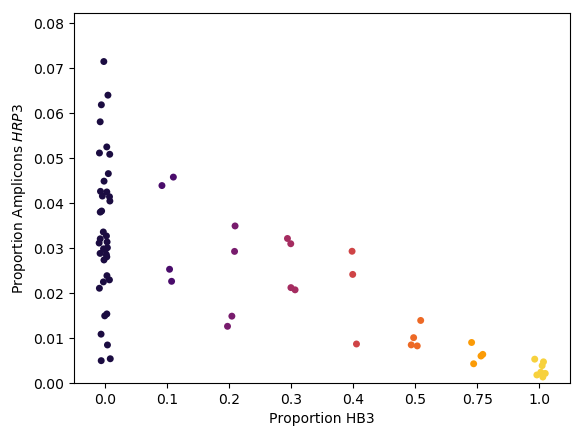

In [226]:
fig, ax = plt.subplots(1, 1)

sns.stripplot(
    x="HB3_prop",
    y="prop_reads_total",
    palette="inferno",
    data=(focus_df
          .query("gene_name == 'HRP3dwn'")
          .query("~ntc")
          .query("barcode_reads_total > 10000")
         )
)

ax.set_xlabel("Proportion HB3")
ax.set_ylabel("Proportion Amplicons $HRP3$")

ax.set_ylim((0, ax.get_ylim()[1]))